# Problem Statement
With the vast amount of books available in the Google Books dataset, it can be challenging for publishers or platforms to predict the potential popularity of a book. By leveraging machine learning, I aim to predict the Average Rating of a book based on its metadata (e.g., title, authors, publisher, categories, etc.). This can help publishers better understand what factors contribute to a book's success and guide decisions in marketing or acquisitions.

### Machine Learning Goal
To build a predictive model that estimates a book's Average Rating using its metadata features.

In [1]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import fnmatch

# from library.sb_utils import save_file


In [2]:
# write a function to look for downloaded data
# the function should look for data and load it into a dataframe

def load_data(directory, search_string):
    # dictionary to store matching file paths
    dataframes = {}
    counter = 1
    
    # walk through the directort and its subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            # check if the file name contains the search_string
            if fnmatch.fnmatch(file.lower(), f"*{search_string.lower()}*"):
                # load each file into a dataframe
                df = pd.read_csv(os.path.join(root, file))
                
                # dynamically name each dataframe
                dataframes[f'df_{counter}'] = df

                # increment counter
                counter += 1

    return dataframes

In [3]:
path = r'C:\Users\adame\OneDrive\Desktop\python_scripts\data_projects\google_books'
file_name = 'random_books'
dataframes_dict = load_data(path, file_name)

In [4]:
# Assuming dataframes_dict contains your DataFrames
dataframes = list(dataframes_dict.values())  # Extract all DataFrames from the dictionary

# Concatenate all DataFrames vertically
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.shape

(180995, 10)

In [5]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180995 entries, 0 to 180994
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          180969 non-null  object 
 1   Authors        124322 non-null  object 
 2   Publisher      86013 non-null   object 
 3   PublishedDate  179505 non-null  object 
 4   ISBN           94380 non-null   float64
 5   PageCount      177863 non-null  float64
 6   Categories     125108 non-null  object 
 7   AverageRating  32889 non-null   float64
 8   RatingsCount   32889 non-null   float64
 9   Language       180995 non-null  object 
dtypes: float64(4), object(6)
memory usage: 13.8+ MB


Well! A lot of books were fetched, but some of these columns have a lot of missing data. 

These columns will be important to the model training. The missing data will have to be dropped.

## Explore the data

In [6]:
combined_df.head()

,Title,Authors,Publisher,PublishedDate,ISBN,PageCount,Categories,AverageRating,RatingsCount,Language
0,The Berenstains' B Book,"Stan Berenstain, Jan Berenstain",Random House Books for Young Readers,1971,NaN,36.0,Juvenile Nonfiction,NaN,NaN,en
1,"B, Book, and Me",Sa-gwa Kim,NaN,2020,9.781932e+12,0.0,Young Adult Fiction,NaN,NaN,en
2,Option B,"Sheryl Sandberg, Adam Grant",Knopf,2017-04-24,9.781525e+12,241.0,Biography & Autobiography,NaN,NaN,en
3,My 'o' Sound Box,Jane Belk Moncure,Jane Belk Moncure Collection,2018-08,9.781504e+12,0.0,Alphabet,NaN,NaN,en
4,XOM-B,Jeremy Robinson,Macmillan,2014-04-29,9.781250e+12,353.0,Fiction,NaN,NaN,en


### Inspect missing values

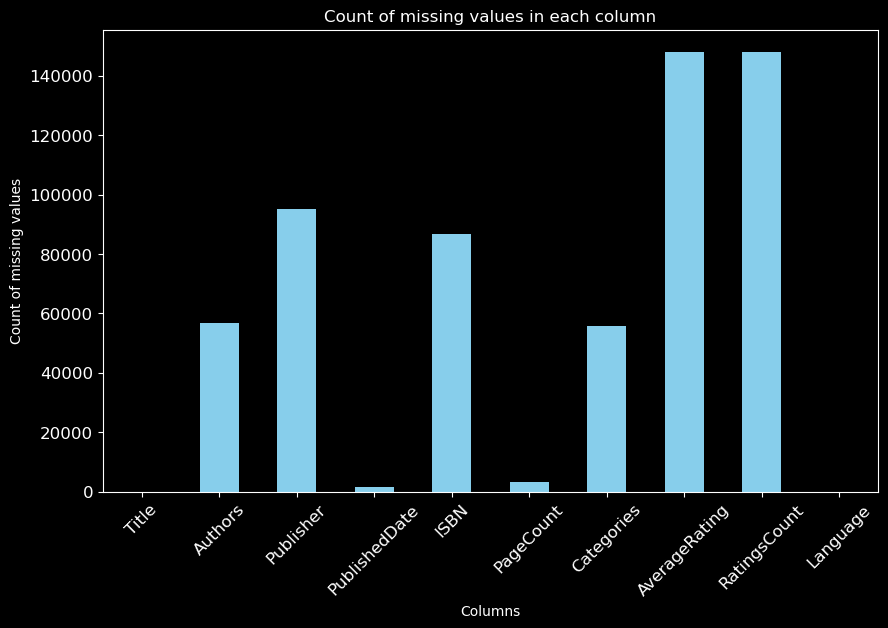

In [7]:
# check for missing values, simple histogram of counts of missing values in each column
combined_df.isna().sum().plot(kind='bar',
                              title='Count of missing values in each column',
                              xlabel='Columns',
                              ylabel='Count of missing values',
                              figsize=(10, 6),
                              color='skyblue',
                              rot=45,
                              fontsize=12)
plt.show()

In [8]:
# drop all missing values
combined_df.dropna(inplace=True)

In [9]:
# change `PageCount`` to integer, instead of float
combined_df['PageCount'] = combined_df['PageCount'].astype(int)

# change `RatingsCount` to integer, instead of float
combined_df['RatingsCount'] = combined_df['RatingsCount'].astype(int)

# change `ISBN` to object, instead of float
combined_df['ISBN'] = combined_df['ISBN'].astype(object)
# remove '.0' from `ISBN` column
combined_df['ISBN'] = combined_df['ISBN'].apply(lambda x: str(x).replace('.0', ''))

In [10]:
# drop rows with 'PageCount' == 0
zero_pages = combined_df[combined_df['PageCount'] == 0]
combined_df.drop(zero_pages.index, inplace=True)

### Inspect the `PublishedDate` column

In [11]:
# check that all published dates are the same format, and have YYYY-MM-DD, I think some have only YYYY
combined_df['PublishedDate'].astype(str).str.contains(r'\d{4}-\d{2}-\d{2}').all()

False

In [12]:
# find all rows with only year in the 'PublishedDate' column
year_only = combined_df['PublishedDate'].str.match(r'^\d{4}$')
year_only.sum()

3134

In [13]:
# add '-01-01' to the end of the year only rows
combined_df.loc[year_only, 'PublishedDate'] = combined_df.loc[year_only, 'PublishedDate'] + '-01-01'

In [14]:
# convert the PublishedDate column to datetime
combined_df['PublishedDate'] = pd.to_datetime(combined_df['PublishedDate'], errors='coerce')

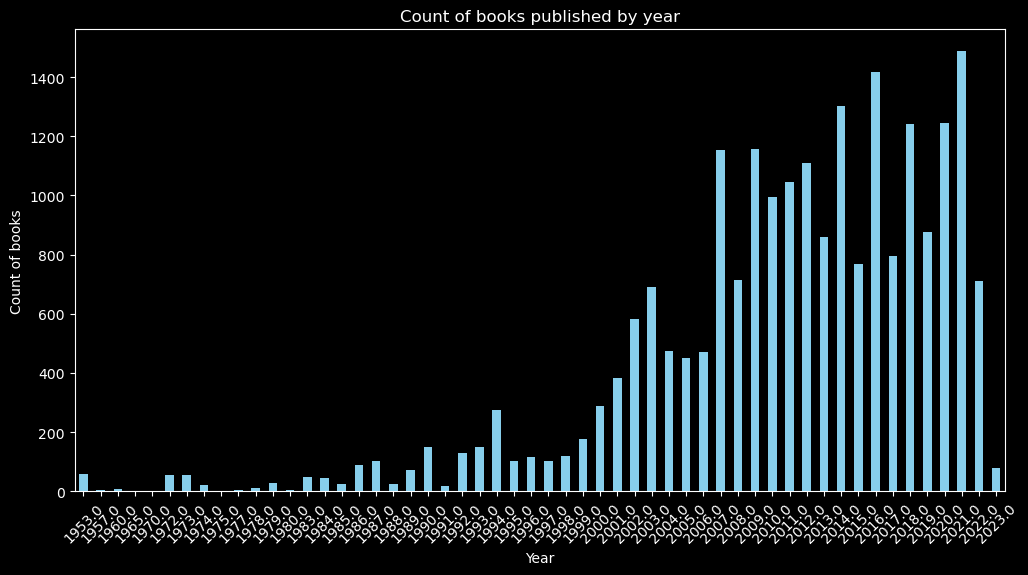

In [15]:
# check the distribution of books published by year
combined_df['PublishedDate'].dt.year.value_counts().sort_index().plot(kind='bar', figsize=(12, 6), color='skyblue', rot=45)
plt.title('Count of books published by year')
plt.xlabel('Year')
plt.ylabel('Count of books')
plt.show()

### Look for duplicates

In [16]:
combined_df.duplicated().sum()

20952

In [17]:
# huh, this cant be right, ill investigate
combined_df['ISBN'].value_counts()

ISBN
9780062457738    137
9781465457752    106
9780399588594    104
9780230553897    103
9780804172707     97
                ... 
9780545649469      1
9781933967561      1
9780811853620      1
9781450065443      1
9781441228819      1
Name: count, Length: 1789, dtype: int64

In [18]:
# this ISBN is supposed to be unique, there cant possibly 137 books with the same ISBN...
combined_df[combined_df['ISBN'] == '9780062457738']

,Title,Authors,Publisher,PublishedDate,ISBN,PageCount,Categories,AverageRating,RatingsCount,Language
13734,The Subtle Art of Not Giving a F*ck,Mark Manson,HarperCollins,2016-09-13,9780062457738,197,Self-Help,4.0,17,en
14874,The Subtle Art of Not Giving a F*ck,Mark Manson,HarperCollins,2016-09-13,9780062457738,197,Self-Help,4.0,17,en
30647,The Subtle Art of Not Giving a F*ck,Mark Manson,HarperCollins,2016-09-13,9780062457738,197,Self-Help,4.0,17,en
30708,The Subtle Art of Not Giving a F*ck,Mark Manson,HarperCollins,2016-09-13,9780062457738,197,Self-Help,4.0,17,en
30727,The Subtle Art of Not Giving a F*ck,Mark Manson,HarperCollins,2016-09-13,9780062457738,197,Self-Help,4.0,17,en
...,...,...,...,...,...,...,...,...,...,...
180860,The Subtle Art of Not Giving a F*ck,Mark Manson,HarperCollins,2016-09-13,9780062457738,197,Self-Help,4.0,17,en
180931,The Subtle Art of Not Giving a F*ck,Mark Manson,HarperCollins,2016-09-13,9780062457738,197,Self-Help,4.0,17,en
180948,The Subtle Art of Not Giving a F*ck,Mark Manson,HarperCollins,2016-09-13,9780062457738,197,Self-Help,4.0,17,en
180963,The Subtle Art of Not Giving a F*ck,Mark Manson,HarperCollins,2016-09-13,9780062457738,197,Self-Help,4.0,17,en


In [ ]:
# lame
combined_df[combined_df['ISBN'] == '9781465457752']

,Title,Authors,Publisher,PublishedDate,ISBN,PageCount,Categories,AverageRating,RatingsCount,Language
30400,The History Book,DK,Penguin,2016-09-16,9781465457752,756,History,1.0,1,en
30627,The History Book,DK,Penguin,2016-09-16,9781465457752,756,History,1.0,1,en
31170,The History Book,DK,Penguin,2016-09-16,9781465457752,756,History,1.0,1,en
31246,The History Book,DK,Penguin,2016-09-16,9781465457752,756,History,1.0,1,en
31352,The History Book,DK,Penguin,2016-09-16,9781465457752,756,History,1.0,1,en
...,...,...,...,...,...,...,...,...,...,...
180180,The History Book,DK,Penguin,2016-09-16,9781465457752,756,History,1.0,1,en
180215,The History Book,DK,Penguin,2016-09-16,9781465457752,756,History,1.0,1,en
180249,The History Book,DK,Penguin,2016-09-16,9781465457752,756,History,1.0,1,en
180523,The History Book,DK,Penguin,2016-09-16,9781465457752,756,History,1.0,1,en


In [20]:
# drop em
combined_df = combined_df.drop_duplicates(subset='ISBN')

In [21]:
combined_df['ISBN'].value_counts()

ISBN
9781316351925    1
9781976182198    1
9781608685400    1
9781626255951    1
9781414329598    1
                ..
9781101148723    1
9783540002901    1
9781441971883    1
9780323141437    1
9780191504259    1
Name: count, Length: 1789, dtype: int64

In [22]:
len(combined_df)

1789

### Inspect the `Authors` column

### Inspect the `Publisher` column

### this column needs more work

In [23]:
# Get unique publishers
unique_publishers = combined_df['Publisher'].unique()
unique_publishers

array(['Cambridge University Press', 'Bantam', 'Zondervan',
       'HarperCollins UK', 'Harper Collins', 'HarperCollins',
       'Oxford University Press, USA', 'Grupo Nelson', 'Triumph Books',
       'Pearson', 'Penguin', 'Knopf', 'Scholastic Inc.', 'Random House',
       'Tor Books', 'University of Chicago Press',
       'Houghton Mifflin Harcourt', 'Alfred Music Publishing',
       'Scholastic', 'Anchor', 'Hachette Books', 'Canongate Books',
       'Little, Brown', 'Tor Nightfire', 'Sourcebooks, Inc.',
       'Samurai Media Limited', 'Little, Brown Books for Young Readers',
       'Univ of California Press', 'Tyndale House Publishers, Inc.',
       'W W Norton & Company Incorporated', 'SAGE Publications',
       'PuddleDancer Press', 'Random House Books for Young Readers',
       'Simon and Schuster', 'Bloomsbury Publishing',
       'Oxford University Press - Children', 'Elsevier', 'Tordotcom',
       'Stanford University Press', 'Nursesbooks.org',
       'Black Classic Press', 'Fab

In [24]:
# %pip install thefuzz
from thefuzz import process

# Example of using fuzzy matching to find similar publisher names
choices = unique_publishers
matches = process.extract("HarperCollins", choices, limit=5)
print(matches)


[('HarperCollins', 100), ('Harper Collins', 96), ('HarperCollins UK', 95), ('HarperCollins Leadership', 90), ('Harpercollins Pub Limited', 90)]


In [25]:
# repair the values
combined_df['Publisher'] = combined_df['Publisher'].replace({'HarperCollins':'Harper Collins', 
                                                             'HarperCollins UK':'Harper Collins', 
                                                             'HarperCollins Leadership':'Harper Collins',
                                                             'Harpercollins Pub Limited':'Harper Collins'})

In [26]:
# Count occurrences of each publisher to verify consistency
# publisher_counts_after = combined_df['Publisher'].sort_values(by='Title')
# print(publisher_counts_after.head(50))


### Inspect the `Categories` column

In [ ]:
combined_df['Categories'].value_counts()

Categories
Fiction                            343
Juvenile Fiction                   260
Biography & Autobiography          150
Computers                          102
Business & Economics                98
                                  ... 
Asymmetric warfare                   1
Earth sciences                       1
Self-actualization (Psychology)      1
California                           1
Adventure stories                    1
Name: count, Length: 98, dtype: int64

In [28]:
combined_df['Categories'].head(98)

9                     Mathematics
22                        Fiction
42               Juvenile Fiction
65      Biography & Autobiography
83               Juvenile Fiction
                  ...            
1952                    Reference
1967                    Computers
1973         Business & Economics
1981                      Fiction
1985                    Computers
Name: Categories, Length: 98, dtype: object

In [ ]:
combined_df[combined_df['Categories'] == 'Computers']

,Title,Authors,Publisher,PublishedDate,ISBN,PageCount,Categories,AverageRating,RatingsCount,Language
220,Thinking in C++,Bruce Eckel,Pearson,2000-01-01,9780139798092,834,Computers,4.5,18,en
427,HT THINK LIKE A COMPUTER SCIEN,"Jeffrey Elkner, Allen B. Downey, Chris Meyers",Samurai Media Limited,2016-10-04,9789888406784,306,Computers,5.0,1,en
1447,The Mythical Man-Month,Frederick P. Brooks Jr.,Pearson Education,1995-08-02,9780132119160,348,Computers,4.5,6,en
1934,R for Data Science,"Hadley Wickham, Garrett Grolemund","""O'Reilly Media, Inc.""",2016-12-12,9781491910368,521,Computers,5.0,1,en
1938,The Book of R,Tilman M. Davies,No Starch Press,2016-07-16,9781593276515,833,Computers,1.0,1,en
...,...,...,...,...,...,...,...,...,...,...
170813,Patterns of Enterprise Application Architecture,Martin Fowler,Addison-Wesley,2012-03-09,9780133065213,558,Computers,3.0,8,en
174688,Python Cookbook,"Alex Martelli, Anna Ravenscroft, David Ascher","""O'Reilly Media, Inc.""",2005-03-18,9780596554743,847,Computers,3.5,15,en
174709,C++ Primer Plus,Stephen Prata,Addison-Wesley Professional,2011-10-18,9780321776402,1435,Computers,5.0,1,en
174745,The The Modern C++ Challenge,Marius Bancila,Packt Publishing Ltd,2018-05-23,9781788994026,321,Computers,5.0,1,en


### Inspect the `Language` column

In [30]:
combined_df['Language'].value_counts()

Language
en    1787
es       1
ar       1
Name: count, dtype: int64

### Inspect the `PageCount` column

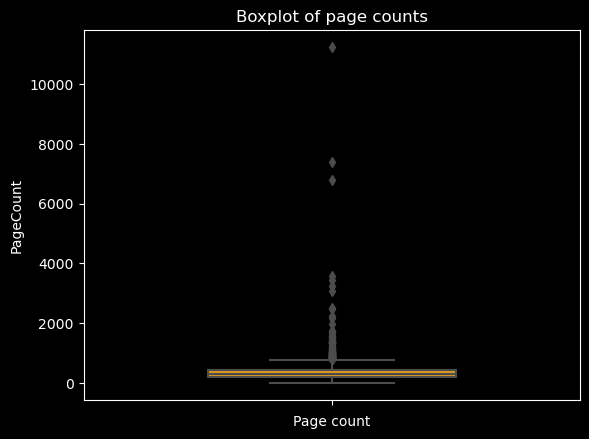

In [31]:
# boxplot of page counts
sns.boxplot(data=combined_df, 
            y='PageCount', 
            color='orange', 
            width=0.5, 
            linewidth=1.5, 
            fliersize=5,
            whis=1.5,            )
plt.title('Boxplot of page counts')
plt.xlabel('Page count')
plt.show()

c:\Users\adame\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


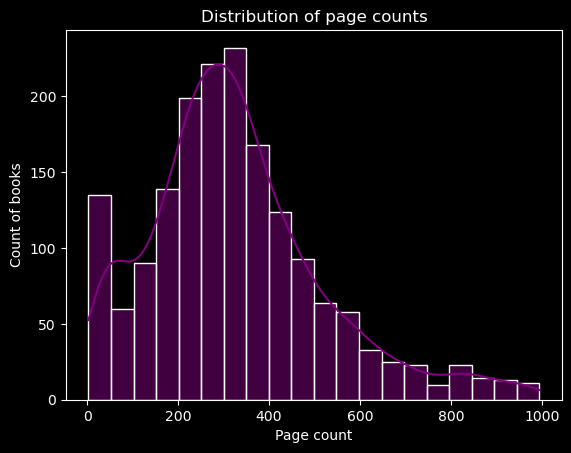

In [32]:
# this plot looks crazy, let's check the distribution of page counts with books that have less than 1000 pages
sns.histplot(data=combined_df[combined_df['PageCount'] < 1000], x='PageCount', bins=20, kde=True, color='purple')
plt.title('Distribution of page counts')
plt.xlabel('Page count')
plt.ylabel('Count of books')
plt.show()

c:\Users\adame\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


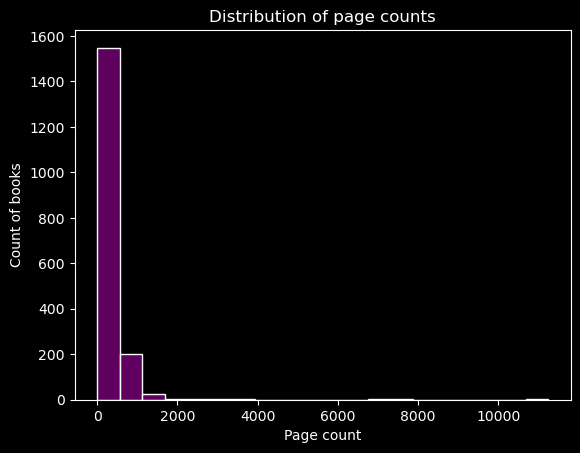

In [33]:
# plot the distribution of page counts
sns.histplot(data=combined_df, x='PageCount', bins=20, color='purple')
plt.title('Distribution of page counts')
plt.xlabel('Page count')
plt.ylabel('Count of books')
plt.show()

### Inspect the `RatingsCount` column

c:\Users\adame\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


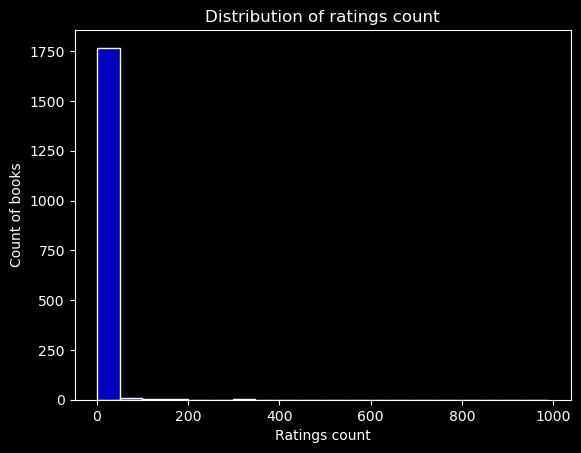

In [34]:
# check the distribution of ratings count
sns.histplot(data=combined_df, x='RatingsCount', bins=20, color='blue')
plt.title('Distribution of ratings count')
plt.xlabel('Ratings count')
plt.ylabel('Count of books')
plt.show()

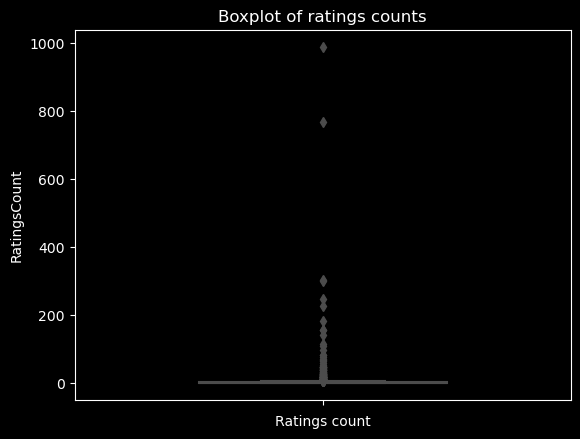

In [35]:
# plot ratings boxplot
sns.boxplot(data=combined_df, 
            y='RatingsCount', 
            color='orange', 
            width=0.5, 
            linewidth=1.5, 
            fliersize=5,
            whis=1.5,            )
plt.title('Boxplot of ratings counts')
plt.xlabel('Ratings count')
plt.show()


In [36]:
combined_df['RatingsCount'].value_counts()

RatingsCount
1      952
2      300
3      159
4       83
5       60
      ... 
64       1
989      1
55       1
248      1
82       1
Name: count, Length: 61, dtype: int64

### Inspect the `AverageRating` column

c:\Users\adame\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


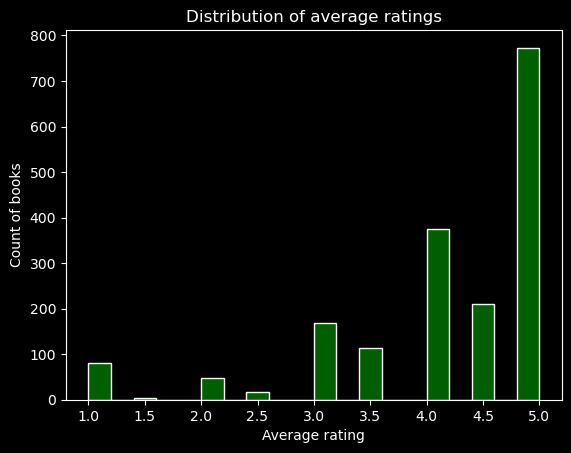

In [37]:
# plot the distribution of average ratings
sns.histplot(data=combined_df, 
             x='AverageRating', 
             bins=20, 
             color='green')
plt.title('Distribution of average ratings')
plt.xlabel('Average rating')
plt.ylabel('Count of books')
plt.show()

## Feature engineering

In [38]:
# add a column for the number of words in the title
combined_df['TitleWordCount'] = combined_df['Title'].str.split().apply(len)

In [39]:
combined_df.columns, combined_df.shape

(Index(['Title', 'Authors', 'Publisher', 'PublishedDate', 'ISBN', 'PageCount',
        'Categories', 'AverageRating', 'RatingsCount', 'Language',
        'TitleWordCount'],
       dtype='object'),
 (1789, 11))

In [40]:
combined_df.head()

,Title,Authors,Publisher,PublishedDate,ISBN,PageCount,Categories,AverageRating,RatingsCount,Language,TitleWordCount
9,The Theory of H(b) Spaces: Volume 2,"Emmanuel Fricain, Javad Mashreghi",Cambridge University Press,2016-10-20,9781316351925,641,Mathematics,5.0,1,en,7
22,The Story of B,Daniel Quinn,Bantam,2010-01-13,9780307575234,350,Fiction,4.5,16,en,4
42,So B. It,Sarah Weeks,Zondervan,2009-10-20,9780061978777,276,Juvenile Fiction,2.0,3,en,3
65,"Ramble Book: Musings on Childhood, Friendship,...",Adam Buxton,Harper Collins,2020-09-03,9780008293352,348,Biography & Autobiography,5.0,1,en,11
83,Jumping the Scratch,Sarah Weeks,Harper Collins,2009-10-20,9780061978791,196,Juvenile Fiction,5.0,1,en,3


In [41]:
# combined_df.to_csv('combined_books.csv', index=False)